<h3>
    Brief Dataset Introduction: Global Lightning Data 2010-2020 </h3>
    
This is a brief introduction to a geospatial dataset (a spatiotemporal dataset for lightning) displayed in the context of California. 
<br>It is meant to showcase the data and to suggest some other datasets with which it can be combined for further research. A particular example is wildfire ignition.


<h4>Brief Data Description </h4> 
    
WGLC Global Gridded Lightning Climatology and Time Series is a dataset for global lightning frequency and intensity statistics from 2010-2020 compiled and processed by Kaplan and Lau as presented in their paper*.

<h4>Brief Data Motivation</h4>
Lightning is a major cause of wildfire ignition. Given the frequency and intensity of wildfires seen around the world in 2021 and in the preceeding years, it may make sense to introduce a spatial lightning dataset. This dataset may then be combined with other spatial datasets such as drought (https://wrcc.dri.edu/wwdt/) and vegetation cover (https://wildlife.ca.gov/Data/GIS/Vegetation-Data for California) to assess wildfire ignition risk and plan for it accordingly.


<br>In the author's (Kaplan and Lau) words*:
<h5>"Among the applications for which the WGLC may be suitable, a few that stand out include modeling global wildfire and atmospheric chemistry, and risk and hazard assessment, particularly in regions of the world where no other lightning detection networks exist. Because the WGLC is a homogeneous global dataset it is possible to directly compare lightning observations between locations without the inter-network calibration that would be required to analyze data from different regional networks perhaps using different technologies. WGLC will be particularly useful for understanding the patterns of natural, i.e., non- human caused, wildfire ignitions in remote locations such as boreal and tropical forests and in areas of the developing world currently undergoing rapid land use change."</h5>
 
<br> 
<h4>Briefly About the Dataset Structure</h4>
Data is presented at 5 and 30 minute resolutions and with daily (only 30m), monthly frequencies as well as monthly averages over the period. 

Some file naming conventions for the data: (as far as I can see)
<li> (_05m, _30m) refer to location resolution where m stands for minute (i.e. 1/60th of a degree). 
<li> (timeseries*daily, timeseries, climatology) respectively refer to  daily and monthly aggregations as well as monthly averages across years (2010-2020).

<br>  
<h4>Path Ahead for the Rest of the Introduction</h4>
I will present lightning density for the state of California at 5 minute spatial resolution across 12 months of the year averaged over years 2010 through 2020.
    
    The code will illustrate 
    <li>how to convert the data from its original form into pandas, <li>manipulate the resulting dataframe, convert it into a geodataframe, filter that with a geography of one's choosing and finally <li>graph the monthly climatological lightning density average.
      
<br> 
<h4>Reference</h4>    
*The WGLC global gridded lightning climatology and time series  
Jed O. Kaplan and Katie Hong-Kiu Lau  
Earth Syst. Sci. Data, 13, 3219–3237,  
https://doi.org/10.5194/essd-13-3219-2021
, 2021

    
Github page for the dataset: https://github.com/ARVE-Research/WGLC






In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr

In [2]:
#Walk the directory and process the data files.
data_dir = "." 
dfs = {}
for root, dirs, files in os.walk(data_dir):
    for _f in files:
        if _f.split('.')[-1]=='nc':
            if _f.find('daily')>0 or _f.find('timeseries')>0:
                print('{0:30}: File not processed. (Resource concern for this notebook)'.format(_f))
            else:   
                print('{0:30}: Processed.'.format(_f))
                ds = xr.open_dataset(root+"/"+_f)
                dfs[_f] = ds.to_dataframe()

wglc_climatology_05m.nc       : Processed.
wglc_timeseries_05m.nc        : File not processed. (Resource concern for this notebook)
wglc_timeseries_30m.nc        : File not processed. (Resource concern for this notebook)
wglc_climatology_30m.nc       : Processed.
wglc_timeseries_30m_daily.nc  : File not processed. (Resource concern for this notebook)


In [3]:
#Load climatology data.
clm_05m_df = dfs['wglc_climatology_05m.nc']
print(clm_05m_df.info())
clm_05m_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 111974400 entries, (-89.9583333333333, -179.958333333333, cftime.DatetimeNoLeap(0, 1, 1, 0, 0, 0, 0, has_year_zero=True)) to (89.9583333333333, 179.958333333333, cftime.DatetimeNoLeap(0, 12, 1, 0, 0, 0, 0, has_year_zero=True))
Data columns (total 1 columns):
 #   Column   Dtype  
---  ------   -----  
 0   density  float32
dtypes: float32(1)
memory usage: 961.3+ MB
None


density
lat        lon         time                        
-89.958333 -179.958333 0000-01-01 00:00:00      0.0
                       0000-02-01 00:00:00      0.0
                       0000-03-01 00:00:00      0.0
                       0000-04-01 00:00:00      0.0
                       0000-05-01 00:00:00      0.0

In [4]:
#Filter for approximate California Coordinates
def filter_lat_lon(df, min_lat, max_lat, min_lon, max_lon):
    df = df[df['lon']>=min_lon]
    df = df[df['lon']<=max_lon]
    df = df[df['lat']>=min_lat]
    df = df[df['lat']<=max_lat]
    return df
    
cali_lat_lon = (32, 44, -130, -114)

clm_05m_df = clm_05m_df.reset_index()

clm_05m_df = filter_lat_lon(clm_05m_df, *cali_lat_lon)

clm_05m_df['month'] = clm_05m_df['time'].apply(lambda x: getattr(x,'month'))

print(clm_05m_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331776 entries, 75900960 to 83316383
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   lat      331776 non-null  float64
 1   lon      331776 non-null  float64
 2   time     331776 non-null  object 
 3   density  331776 non-null  float32
 4   month    331776 non-null  int64  
dtypes: float32(1), float64(2), int64(1), object(1)
memory usage: 13.9+ MB
None


In [5]:
#Pivot the data to move monthly density data to their own columns
clm_05m_df = clm_05m_df.pivot_table(columns=['lat', 'lon','month'], values=['density'] ).T

clm_05m_df = clm_05m_df.unstack(['month']).reset_index()

clm_05m_df.columns = ['lat', 'lon']+['Month_{0:d}'.format(_) for _ in range(1,13)]

clm_05m_df.head()

,lat,lon,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,32.041667,-129.958333,0.000242,0.000223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,32.041667,-129.875000,0.000161,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,32.041667,-129.791667,0.000645,0.000134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000242,0.0,0.000081
3,32.041667,-129.708333,0.000322,0.000312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000121,0.0,0.000081
4,32.041667,-129.625000,0.000000,0.000580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000081


In [6]:
#Convert to geopandas.GeoDataFrame

clm_05m_df['geometry'] = gpd.points_from_xy(clm_05m_df['lon'], clm_05m_df['lat'])

clm_05m_gdf = gpd.GeoDataFrame(clm_05m_df)
clm_05m_gdf.crs = 'epsg:4269' #CRS of the California geometry (coming up)

print(clm_05m_gdf.info())
clm_05m_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27648 entries, 0 to 27647
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lat       27648 non-null  float64 
 1   lon       27648 non-null  float64 
 2   Month_1   27648 non-null  float32 
 3   Month_2   27648 non-null  float32 
 4   Month_3   27648 non-null  float32 
 5   Month_4   27648 non-null  float32 
 6   Month_5   27648 non-null  float32 
 7   Month_6   27648 non-null  float32 
 8   Month_7   27648 non-null  float32 
 9   Month_8   27648 non-null  float32 
 10  Month_9   27648 non-null  float32 
 11  Month_10  27648 non-null  float32 
 12  Month_11  27648 non-null  float32 
 13  Month_12  27648 non-null  float32 
 14  geometry  27648 non-null  geometry
dtypes: float32(12), float64(2), geometry(1)
memory usage: 1.9 MB
None


,lat,lon,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,geometry
0,32.041667,-129.958333,0.000242,0.000223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,POINT (-129.95833 32.04167)
1,32.041667,-129.875000,0.000161,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,POINT (-129.87500 32.04167)
2,32.041667,-129.791667,0.000645,0.000134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000242,0.0,0.000081,POINT (-129.79167 32.04167)
3,32.041667,-129.708333,0.000322,0.000312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000121,0.0,0.000081,POINT (-129.70833 32.04167)
4,32.041667,-129.625000,0.000000,0.000580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000081,POINT (-129.62500 32.04167)


epsg:4269


,STATE,NAME,FIPS,LON,LAT,geometry
5,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."


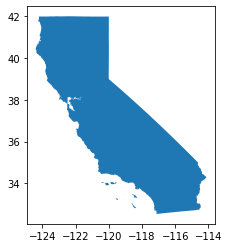

In [7]:
#Load California state data

states_filename = 's_11au16/s_11au16.shp' #National Weather Service Data - https://www.weather.gov/gis/USStates

states_gdf = gpd.read_file(states_filename)
cali_gdf = states_gdf[states_gdf['STATE']=="CA"]

print(states_gdf[states_gdf['STATE']=="CA"].crs)

cali_gdf.plot()
cali_gdf.head()

In [8]:
#Filter for lightning data within California

clm_05m_cali_gdf = gpd.sjoin(clm_05m_gdf, cali_gdf[['geometry']], how='inner', op='within',)
print(clm_05m_cali_gdf.info())
clm_05m_cali_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5997 entries, 1306 to 22967
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   lat          5997 non-null   float64 
 1   lon          5997 non-null   float64 
 2   Month_1      5997 non-null   float32 
 3   Month_2      5997 non-null   float32 
 4   Month_3      5997 non-null   float32 
 5   Month_4      5997 non-null   float32 
 6   Month_5      5997 non-null   float32 
 7   Month_6      5997 non-null   float32 
 8   Month_7      5997 non-null   float32 
 9   Month_8      5997 non-null   float32 
 10  Month_9      5997 non-null   float32 
 11  Month_10     5997 non-null   float32 
 12  Month_11     5997 non-null   float32 
 13  Month_12     5997 non-null   float32 
 14  geometry     5997 non-null   geometry
 15  index_right  5997 non-null   int64   
dtypes: float32(12), float64(2), geometry(1), int64(1)
memory usage: 515.4 KB
None


,lat,lon,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,geometry,index_right
1306,32.541667,-117.125000,0.000000,0.0,0.000162,0.000000,0.000000,0.0,0.000081,0.0,0.000000,0.000000,0.000000,0.000000,POINT (-117.12500 32.54167),5
1307,32.541667,-117.041667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000081,0.0,0.000084,0.000000,0.000377,0.000000,POINT (-117.04167 32.54167),5
1499,32.625000,-117.041667,0.000000,0.0,0.000000,0.000085,0.000000,0.0,0.000000,0.0,0.000084,0.000081,0.000126,0.000000,POINT (-117.04167 32.62500),5
1500,32.625000,-116.958333,0.000000,0.0,0.000081,0.000000,0.000000,0.0,0.000000,0.0,0.000084,0.000000,0.000084,0.000203,POINT (-116.95833 32.62500),5
1501,32.625000,-116.875000,0.000082,0.0,0.000243,0.000000,0.000081,0.0,0.000000,0.0,0.000336,0.000000,0.000251,0.000284,POINT (-116.87500 32.62500),5


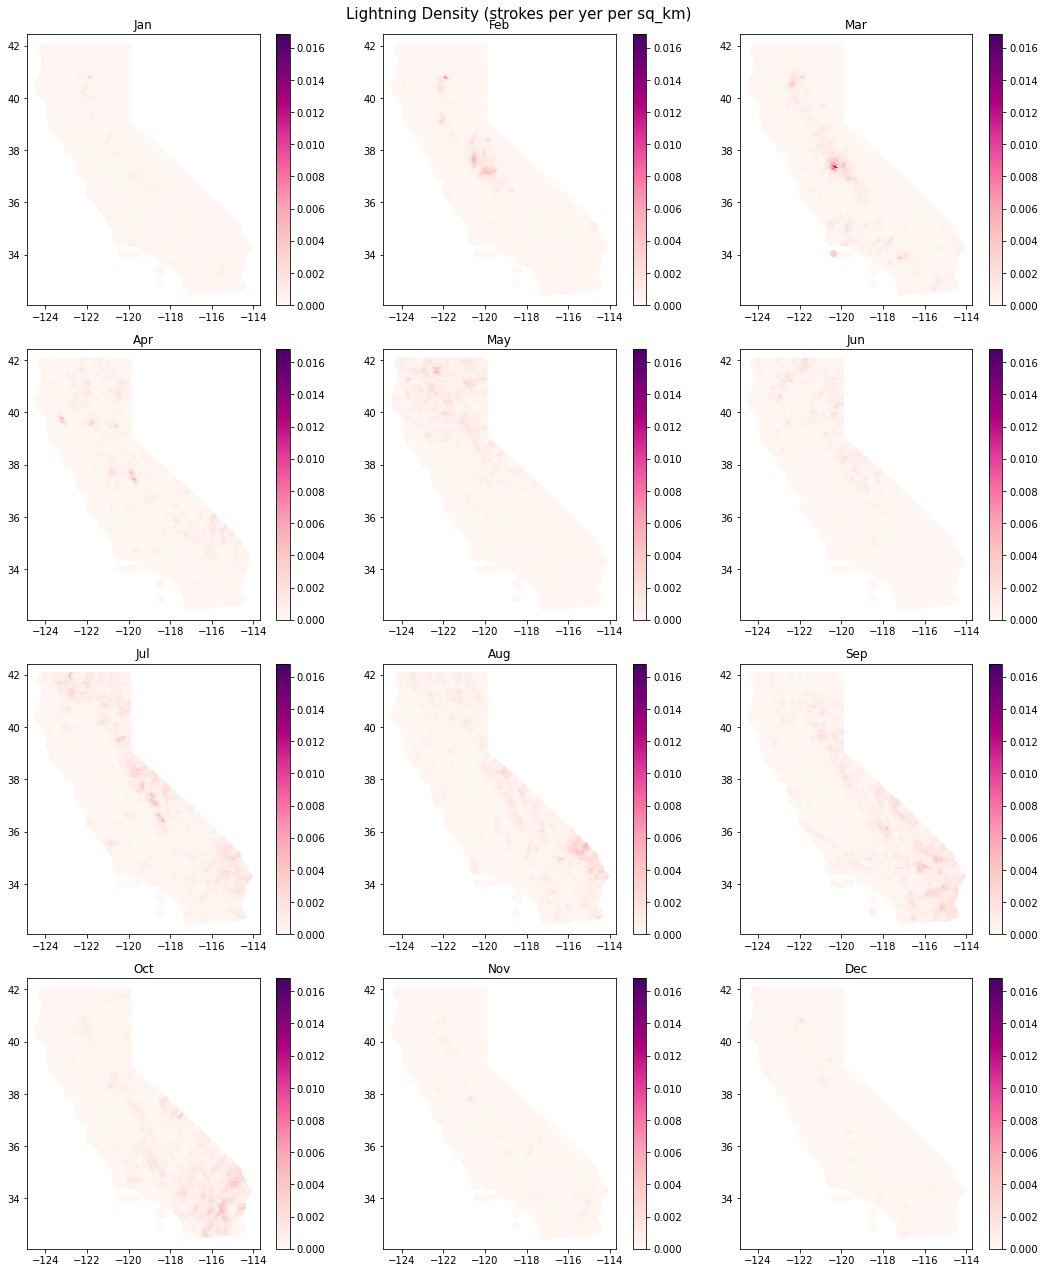

In [9]:
#Plot  Lightning Density

m_dict = dict(zip(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

d_max = clm_05m_cali_gdf.filter(regex='Month_*').max().max()
d_min = clm_05m_cali_gdf.filter(regex='Month_*').min().min()  #common scales for colorbars

cmap = 'RdPu'

fig, axes = plt.subplots(4, 3, figsize=(15,18))

for r in range(4):
    for c in range(3):
        month = 3*r + c + 1
        axes[r][c] = clm_05m_cali_gdf.plot(column='Month_{0:d}'.format(month), cmap=cmap, ax=axes[r][c], legend=True, vmax=d_max, vmin=d_min,  )
        axes[r][c].set_title(m_dict[month])
fig.suptitle('Lightning Density (strokes per yer per sq_km)', fontsize = 15)
fig.set_tight_layout(tight=True)
plt.show()